### MOTIF-BASED EXPLAINER

This notebook represents the analysis of the previously built datasets to explain changes in inclusion levels of Knockdown responsive exons just based on motif ocurrences. 
Each RBP represents a dataset. Ideally, the motifs that would explain given dPSI values (or exon strength) would highlight the RBPs that were knockdown in the given experiment. 

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import glob
from tqdm import tqdm
tqdm.pandas()
pd.set_option('display.width', 1000)
import matplotlib.pyplot as plt
from explainer.datasets.tabular_dataset import TabularDataset
from gtfhandle.utils import file_to_bed_df

join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


Let's import the spliceAI predictions for all the union of the different exons present in all the datasets

In [2]:
# SpliceAI predictions for all exon coordinates (with mutsplice off) in which spliceAI is run considering a set of independent sequences
SPLICEAI_PREDS_PATH = "/Users/pbarbosa/Desktop/NFS_Pedro/phd/rbp_data/HepG2/1_paired_datasets_spliceAI_preds/1_spliceAI_preds_ALL/FINAL_SPLICEAI_PREDS.tsv.gz"
PER_RBP_MOTIF_SCANNING = "/Users/pbarbosa/Desktop/NFS_Pedro/phd/rbp_data/HepG2/1_paired_datasets_spliceAI_preds/2_individual_datasets"
SPLICEAI_PREDS = pd.read_csv(SPLICEAI_PREDS_PATH, sep="\t", low_memory=False)
SPLICEAI_PREDS = SPLICEAI_PREDS.rename(columns={'target_coordinates': 'exon_coordinates'})
SPLICEAI_PREDS['transcript_id'] = SPLICEAI_PREDS.seq_id.str.split("_").str[1]

# Exons extracted 
EXONS_PATH = '/Users/pbarbosa/git_repos/interpret_splicing/notebooks/1_BUILD_DATASETS/ALL_exons_extracted_controls_per_txtype.tsv.gz'
EXONS = pd.read_csv(EXONS_PATH, sep='\t')
EXONS = EXONS.rename(columns={'RBPs': 'RBP'})
EXONS = EXONS[(EXONS.tx_type == "pc") & (EXONS.analysis == "euclidean_l")]
EXONS = EXONS[['exon_coordinates', 'RBP', 'dPSI', 'gene_name', 'transcript_id', 'exon_group']] 

# GTF CACHE
GTF_CACHE = "/Users/pbarbosa/Desktop/NFS_Pedro/phd/rbp_data/HepG2/cache_gtf/"

# FASTA 
FASTA = "/Users/pbarbosa/MEOCloud/genome_utilities/hg38/GRCh38.primary_assembly.genome.fa"

In [3]:
# Merge predictions 
# cols = ['exon_coordinates', 'RBPs', 'gene_name', 'transcript_id', 'transcript_type', 'GC_target',
#         'Length_target', 'GC_upstream', 'Length_upstream', 'GC_downstream', 'Length_downstream',
#         'exon_group', 'paired_with', 'dPSI', 'analysis', 'tx_type']

EXONS = EXONS.merge(SPLICEAI_PREDS, how='left', on=['exon_coordinates', 'transcript_id'])

# Remove exons that somehow were not predicted (other tx ids assigned making it to first or last exon)
#data_to_ml = data_to_ml[~data_to_ml.isna().any(axis=1)]

In [4]:
def generateDatasets(df: pd.DataFrame, 
                     analysis_name: str,
                     granularity: str,
                     **kwargs):
    """
    Generates tabular datasets
    """
    os.makedirs('tabular_datasets', exist_ok=True)
    
    rbp_name = df.name
    print(rbp_name)
    map_d = {'occurrences_alone': 'S1', 'occurrences_based_on_location': 'S2'}
    analysis_name = map_d.get(analysis_name)
    outdir = PER_RBP_MOTIF_SCANNING + "/" + rbp_name
    
    kwargs['outbasename'] = rbp_name
    
    dt = TabularDataset(df,
                        outdir=outdir,
                        granularity=granularity,
                        normalize_by_length=True,
                        **kwargs)

    #dt.data = dt.data.drop(columns=cols_to_drop + list(dt.data.filter(regex='^len_')))
    dt.data.to_csv(os.path.join('tabular_datasets',
                                '{}_{}_{}.tsv.gz'.format(rbp_name,
                                                         kwargs['motif_source'],
                                                         analysis_name)), 
                   index=False, 
                   compression='gzip',
                   sep="\t")
    
    return dt.data


In [5]:
# CODE TO GENERATE DATASETS
# kwargs = {'subset_rbps': 'encode_in_attract', 
#           'motif_source': 'attract'}

# data_config = {#'occurrences_alone': 'motif'}#,
#                'occurrences_based_on_location': 'per_location'}

# all_datasets = {}
# for analysis, granularity in data_config.items():
#     df = EXONS.groupby(['RBP']).progress_apply(generateDatasets,
#                                                analysis_name=analysis,
#                                                granularity=granularity,
#                                                **kwargs).reset_index(drop=True)

#     all_datasets[analysis] = df


In [4]:
# CODE TO LOAD PROCESSED DATASETS
# Present in lobo with TABULAR_DATASET flag, but also in this repo

s1_files = glob.glob('tabular_datasets/*S1.tsv.gz')
s2_files = glob.glob('tabular_datasets/*S2.tsv.gz')
    
all_datasets = {'occurrences_alone': pd.concat(map(lambda file: pd.read_csv(file, sep="\t"), s1_files)),
               'occurrences_based_on_location': pd.concat(map(lambda file: pd.read_csv(file, sep="\t"), s2_files))}

In [ ]:
# Filter dfs for specific RBP
import sys
for k, v in all_datasets.items():
    all_datasets[k] = v[v.RBP == sys.argv[1]]   

In [7]:
# Drop columns to keep analysis just with motif ocurrences
cols_to_drop = ['exon_coordinates', 'dPSI', 'gene_name', 'transcript_id',
                'ref_donor_cassette', 'ref_acceptor_cassette',
                'ref_acceptor_upstream', 'ref_donor_downstream',
                'ref_donor_upstream', 'ref_acceptor_downstream']

for k, v in all_datasets.items():
    _to_drop = cols_to_drop + list(v.filter(regex='^len_'))
    v.exon_group.replace({'KD': 1, 'KD_sensitive': 1, 'CTRL': 0}, inplace=True)
    all_datasets[k] = v.drop([x for x in _to_drop if x in v.columns], axis=1)

In [8]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import permutation_test_score

def dummy_classifier(df: pd.DataFrame):
    """
    Simple decision tree classifier to distinguish exon group 
    based on motif ocurrences features
    """

    if df.shape[0] > 100:
        
        # Remove features with zeros in all instances
        df = df.loc[:, (df != 0).any(axis=0)]
        
        df = df.drop(['seq_id', 'average_cassette_strength', 'RBP'], axis=1)
        
        x = df.drop('exon_group', axis=1)
        y = df.exon_group


        clf = DummyClassifier(strategy='uniform')
        
        skf = StratifiedKFold(n_splits=5)
        cv_results= cross_validate(clf, x, y, scoring='accuracy', cv=skf, return_estimator=True)
     
        accuracies = []
        
        for i, _ in enumerate(cv_results['estimator']):
            accuracies.append(cv_results['test_score'][i])
            
        return round(np.mean(accuracies), 3), None ,None, None
    else:
        print("Not enough data: {}".format(df.name))
        return

In [9]:
from sklearn import tree
from sklearn.model_selection import cross_validate


def dt_classifier(df: pd.DataFrame):
    """
    Simple decision tree classifier to distinguish exon group 
    based on motif ocurrences features
    """

    if df.shape[0] > 100:
        
        # Remove features with zeros in all instances
        df = df.loc[:, (df != 0).any(axis=0)]
        
        df = df.drop(['seq_id', 'average_cassette_strength', 'RBP'], axis=1)
        
        x = df.drop('exon_group', axis=1)
        y = df.exon_group

        clf = tree.DecisionTreeClassifier(random_state=0, min_samples_leaf=3, max_depth=5)
        skf = StratifiedKFold(n_splits=5)
        cv_results= cross_validate(clf, x, y, scoring='accuracy', cv=skf, return_estimator=True)
        
        _, _, pval = permutation_test_score(clf, x, y, scoring="accuracy", cv=skf, n_permutations=1000)
        
        accuracies, feat_import = [],[]
        
        for i, model in enumerate(cv_results['estimator']):
            # tree.plot_tree(clf, feature_names=x.columns)
            feat_import.append(model.feature_importances_)
            accuracies.append(cv_results['test_score'][i])
            
        return round(np.mean(accuracies), 3), pval, np.array(feat_import).mean(axis=0).tolist(), list(x)

    else:
        print("Not enough data: {}".format(df.name))
        return

In [10]:
from sklearn.ensemble import RandomForestClassifier
def rf_classifier(df: pd.DataFrame):
    """
    Simple random forest classifier to distinguish exon group 
    based on motif ocurrences features
    """
    if df.shape[0] > 100:
        
        # Remove features with zeros in all instances
        df = df.loc[:, (df != 0).any(axis=0)]
        
        df = df.drop(['seq_id', 'average_cassette_strength', 'RBP'], axis=1)
        
        x = df.drop('exon_group', axis=1)
        y = df.exon_group
        
        clf = RandomForestClassifier(max_depth=5, random_state=0)
        skf = StratifiedKFold(n_splits=5)
        cv_results= cross_validate(clf, x, y, scoring='accuracy', cv=skf, return_estimator=True)
        
        _, _, pval = permutation_test_score(clf, x, y, scoring="accuracy", cv=skf, n_permutations=1000)
        accuracies, feat_import = [],[]
        
        for i, model in enumerate(cv_results['estimator']):
            # tree.plot_tree(clf, feature_names=x.columns)
            feat_import.append(model.feature_importances_)
            accuracies.append(cv_results['test_score'][i])
            
        return round(np.mean(accuracies), 3), pval, np.array(feat_import).mean(axis=0).tolist(), list(x)
    
    else:
        print("Not enough data: {}".format(df.name))
        return

In [11]:
import xgboost as xgb
from sklearn.preprocessing import LabelBinarizer

def xgb_classifier(df: pd.DataFrame):
    """
    Simple xgboost classifier to distinguish exon group 
    based on motif ocurrences features
    """
    if df.shape[0] > 100:
        
        # Remove features with zeros in all instances
        df = df.loc[:, (df != 0).any(axis=0)]
        
        df = df.drop(['seq_id', 'average_cassette_strength', 'RBP'], axis=1)
        
        x = df.drop('exon_group', axis=1)
        y = df.exon_group
        y = LabelBinarizer().fit_transform(y).ravel()
        #dtrain = xgb.DMatrix(x, label=y)
    
        params = {'max_depth': 5, 
                  'eta': 0.3,
                  'eval_metric': 'logloss'}

        clf = xgb.XGBClassifier(use_label_encoder=False, **params)
        skf = StratifiedKFold(n_splits=5)
        cv_results= cross_validate(clf, x, y, scoring='accuracy', cv=skf, return_estimator=True)
        
        _, _, pval = permutation_test_score(clf, x, y, scoring="accuracy", cv=skf, n_permutations=1000)
        accuracies, feat_import = [],[]
        
        for i, model in enumerate(cv_results['estimator']):
            # tree.plot_tree(clf, feature_names=x.columns)
            feat_import.append(model.feature_importances_)
            accuracies.append(cv_results['test_score'][i])
            
        return round(np.mean(accuracies), 3), pval, np.array(feat_import).mean(axis=0).tolist(), list(x)
    
    else:
        print("Not enough data: {}".format(df.name))
        return

/Users/pbarbosa/miniconda3/envs/genomics/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [12]:
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold

def svm_classifier(df: pd.DataFrame):
    """
    Simple SVM classifier to distinguish exon group 
    based on motif ocurrences features
    """
    if df.shape[0] > 100:
        
        # Remove features with zeros in all instances
        df = df.loc[:, (df != 0).any(axis=0)]
        
        df = df.drop(['seq_id', 'average_cassette_strength', 'RBP'], axis=1)
        
        x = df.drop('exon_group', axis=1)
        y = df.exon_group
        
        clf = SVC(kernel = 'rbf')
        skf = StratifiedKFold(n_splits=5)
        splits = skf.split(x, y)
        cv_results= cross_validate(clf, x, y, scoring='accuracy', cv=skf, return_estimator=True)
        
        _, _, pval = permutation_test_score(clf, x, y, scoring="accuracy", cv=skf, n_permutations=1000)
        accuracies, feat_import = [],[]
       
        for i, model in enumerate(cv_results['estimator']):
            _i = 0
            for _, test_index in splits:      
                if _i == i:
                    x_test_at_split_i, y_test_at_split_i = x.iloc[test_index], y.iloc[test_index]
                    perm_importance = permutation_importance(model,
                                                             x_test_at_split_i,
                                                             y_test_at_split_i,
                                                             scoring='accuracy')

            feat_import.append(perm_importance['importances_mean'])
            accuracies.append(cv_results['test_score'][i])
            
        return round(np.mean(accuracies), 3), pval, np.array(feat_import).mean(axis=0).tolist(), list(x)
    
    else:
        print("Not enough data: {}".format(df.name))
        return

## Collinearity analysis and feature selection

In [13]:
# %%capture
# from scipy.stats import spearmanr
# from scipy.cluster import hierarchy
# from scipy.spatial.distance import squareform

# def plot_feature_distances(x: pd.DataFrame, name: str):
#     """
#     Plot feature distances
#     """
#     x = x.drop(['seq_id', 'average_cassette_strength', 'RBP'], axis=1)
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

#     corr = spearmanr(x).correlation
#     # Ensure the correlation matrix is symmetric
#     corr = (corr + corr.T) / 2
#     np.fill_diagonal(corr, 1)

#     # We convert the correlation matrix to a distance matrix before performing
#     # hierarchical clustering using Ward's linkage.
#     distance_matrix = 1 - np.abs(corr)
#     dist_linkage = hierarchy.ward(squareform(distance_matrix))
#     dendro = hierarchy.dendrogram(dist_linkage, labels=x.columns if len(list(x)) < 100 else None, ax=ax1, leaf_rotation=90)
#     dendro_idx = np.arange(0, len(dendro["ivl"]))

#     im = ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
#     fig.colorbar(im, ax=ax2, shrink=0.5)
#     if len(list(x)) < 100:
#         ax2.set_xticks(dendro_idx)
#         ax2.set_yticks(dendro_idx)
#         ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
#         ax2.set_yticklabels(dendro["ivl"])
#         fig.tight_layout()
    
#     plt.savefig(name)
#     plt.close()


In [14]:
#Feature selection class to eliminate multicollinearity
# from collections import defaultdict
# class MultiCollinearityEliminator():
    
#     #Class Constructor
#     def __init__(self, df, target, threshold):
#         self.df = df
#         self.target = target
#         self.threshold = threshold
#         self.correlation_pais = defaultdict(list)

#     #Method to create and return the feature correlation matrix dataframe
#     def createCorrMatrix(self, include_target = False):
#         #Checking we should include the target in the correlation matrix

#         if (include_target == False):
#             df_temp = self.df.drop([self.target], axis =1)
            
#             #Setting method to Pearson to prevent issues in case the default method for df.corr() gets changed
#             #Setting min_period to 30 for the sample size to be statistically significant (normal) according to 
#             #central limit theorem
#             corrMatrix = df_temp.corr(method='spearman', min_periods=30).abs()
#         #Target is included for creating the series of feature to target correlation - Please refer the notes under the 
#         #print statement to understand why we create the series of feature to target correlation
#         elif (include_target == True):
#             corrMatrix = self.df.corr(method='spearman', min_periods=30).abs()
    
#         return corrMatrix

#     #Method to create and return the feature to target correlation matrix dataframe
#     def createCorrMatrixWithTarget(self):
#         #After obtaining the list of correlated features, this method will help to view which variables 
#         #(in the list of correlated features) are least correlated with the target
#         #This way, out the list of correlated features, we can ensure to elimate the feature that is 
#         #least correlated with the target
#         #This not only helps to sustain the predictive power of the model but also helps in reducing model complexity
        
#         #Obtaining the correlation matrix of the dataframe (along with the target)
#         corrMatrix = self.createCorrMatrix(include_target = True)       
                 
#         #Creating the required dataframe, then dropping the target row 
#         #and sorting by the value of correlation with target (in asceding order) 
#         corrWithTarget = pd.DataFrame(corrMatrix.loc[:,self.target]).drop([self.target], axis = 0).sort_values(by = self.target)         

#         return corrWithTarget

#     #Method to create and return the list of correlated features
#     def createCorrelatedFeaturesList(self, first_pass: bool):
#         #Obtaining the correlation matrix of the dataframe (without the target)
#         corrMatrix = self.createCorrMatrix(include_target = False)                          
#         colCorr = []
#         #Iterating through the columns of the correlation matrix dataframe
#         for column in corrMatrix.columns:
#             #Iterating through the values (row wise) of the correlation matrix dataframe
  
#             for idx, row in corrMatrix.iterrows():                                        
#                 if(row[column]>self.threshold) and (row[column]<1):
#                     if first_pass:
#                         self.correlation_pais[column].append(idx)
#                     #Adding the features that are not already in the list of correlated features
#                     if (idx not in colCorr):
#                         colCorr.append(idx)
#                     if (column not in colCorr):
#                         colCorr.append(column)
#         #print('Correlated features: {}'.format(colCorr), '\n')
#         return colCorr

#     #Method to eliminate the least important features from the list of correlated features
#     def deleteFeatures(self, colCorr):
#         #Obtaining the feature to target correlation matrix dataframe
#         corrWithTarget = self.createCorrMatrixWithTarget()                                  
#         for idx, row in corrWithTarget.iterrows():

#             if (idx in colCorr):
#                 self.df = self.df.drop(idx, axis =1)
#                 break
            
#         return self.df

#     #Method to run automatically eliminate multicollinearity
#     def autoEliminateMulticollinearity(self):
#         #Obtaining the list of correlated features
#         colCorr = self.createCorrelatedFeaturesList(first_pass=True)    
                                 
#         while colCorr != []:
#             #Obtaining the dataframe after deleting the feature (from the list of correlated features) 
#             #that is least correlated with the taregt
#             self.df = self.deleteFeatures(colCorr)
#             #Obtaining the list of correlated features
#             colCorr = self.createCorrelatedFeaturesList(first_pass=False)                                     
#         return self.df, self.correlation_pais

### Reduce datasets size by removing correlated features

In [24]:
corr_out_dir = 'tabular_datasets/collinearity_analysis'
os.makedirs(corr_out_dir, exist_ok=True)
fs_datasets, correlated_pairs = {}, {}
for dataset_type, df in all_datasets.items():

    map_d = {'occurrences_alone': 'S1', 'occurrences_based_on_location': 'S2'}
    dataset_type_short = map_d.get(dataset_type, dataset_type)
    per_rbp_corr = {}
    for rbp, _data in df.groupby('RBP'):
        
        data = _data.copy()
        
        #Remove features with zeros in all instances
        data = data.loc[:, (data != 0).any(axis=0)]
        
        # Convert targets to integers
        x = data.drop('exon_group', axis=1)
        y = data.exon_group
        
        # Feature clustering and correlation 
        #plot_feature_distances(x, name="{}/{}_{}_feat_corr_raw.pdf".format(corr_out_dir, rbp, dataset_type_short))
        
        # Compute correlation pairs
        _x = x.copy()
        _x = _x.drop(['seq_id', 'average_cassette_strength', 'RBP'], axis=1)
        corr = _x.corr(method='spearman')
        
        filt = corr.apply(lambda row: pd.Series(np.where(row >=0.3, row.index, None)), axis=1)
        corr_pairs = filt.apply(lambda row: list(set([x for x in row if x is not None and x!= row.name])), axis=1).to_dict()
        per_rbp_corr[rbp] = corr_pairs
        
        # Feature selection
        #colinearity = MultiCollinearityEliminator(df=data, target='exon_group', threshold=0.3)
  
        #data_feat_select, corr_pairs = colinearity.autoEliminateMulticollinearity()

        #plot_feature_distances(data_feat_select.drop('exon_group', axis=1), name="{}/{}_{}_feat_corr_FS.pdf".format(corr_out_dir, rbp, dataset_type_short))
        #x = data_feat_select.drop('exon_group', axis=1)
        
        #fs_datasets[dataset_type + "_FS"] = data_feat_select
        
        #data_feat_select.to_csv("{}/{}_{}_FS.tsv.gz".format(corr_out_dir, rbp, dataset_type_short), sep='\t', compression='gzip')
    correlated_pairs[dataset_type] = per_rbp_corr
        
#all_datasets = all_datasets | fs_datasets

In [16]:
from typing import Union
def plotFeatureImportances(df: pd.DataFrame, outdir: str, 
                           basename:str, 
                           correlated_pairs: dict = None, 
                           ranks_pval: Union[pd.Series, pd.DataFrame] = None):
 
    def _draw(df, rbp: str, basename:str, ranks_pval, is_correlated_feat: bool = False):
            
        clrs = ['maroon' if x is True else 'grey' for x in df.is_target]
        
        fig, ax = plt.subplots(figsize=(10, 9))
        print(df)
        g = sns.barplot(x='feat_import', y='feat_names_l' if 'feat_names_l' in df.columns else 'feat_names', orient='h', palette=clrs, data=df.head(40))
    
        try:
            idx = clrs.index('maroon')
            for i, p in enumerate(g.patches):

                if i == idx:
               
                    g.annotate('pval: {}'.format(str(ranks_pval[rbp][1]) if is_correlated_feat is False else str(ranks_pval[rbp][3])), 
                            xy=(p.get_x() + p.get_width() + 0.001, p.get_y()), 
                            ha = 'left', va = 'top')#,
                    #       textcoords = 'offset points')

        except ValueError:
            a=1
            
        if is_correlated_feat:
            out = '{}/{}_{}_feat_import_using_corrFeat.pdf'.format(outdir, rbp, basename)
        else:
            out = '{}/{}_{}_feat_import.pdf'.format(outdir, rbp, basename)
            
        plt.tight_layout()
        plt.savefig(out)
        plt.close()

    rbp = df.name
    df = df[df.feat_import > 0].sort_values('feat_import', ascending=False)
    
    if df.empty:
        return 
    
    if correlated_pairs is not None:
        
        corr_feat_at_rbp = correlated_pairs[rbp]
        df['feat_names_l'] = df.feat_names.apply(lambda x: x + " (n_corr={})".format(str(len(corr_feat_at_rbp[x]))))
    
    # True RBP-related values    
    _target_features = df[df.feat_names.str.contains(rbp)].feat_names  
    df['is_target'] = df.feat_names.isin(_target_features) 
    _draw(df, rbp, basename, ranks_pval)
    
    # Accounting for highly correlated features
    if all(x is not None for x in [correlated_pairs, ranks_pval]):
        
        corr_feat_at_rbp = correlated_pairs[rbp][rbp] + df[df.feat_names.str.contains(rbp)].feat_names.tolist()

        mask = df.feat_names.str.contains('|'.join(corr_feat_at_rbp))
        df['is_target'] = mask
  
        _draw(df, rbp, basename, ranks_pval, is_correlated_feat=True) 
        


In [17]:
import random
def do_simulations(feat_names, target_features, rank_target):
    n_permutations = 1000
    
    smaller_rank = 0
    for i in range(n_permutations):
    
        #shuffling inplace
        random.shuffle(feat_names)

        _target_features = feat_names[feat_names.isin(target_features)]  
        _target_features_rank = _target_features.index[0]
 
        if _target_features_rank < rank_target:
            smaller_rank += 1

    pval = smaller_rank / n_permutations       
    return pval

def testRanksOfImportances(df: pd.DataFrame, correlated_pairs: dict = None):
    rbp== df.name
    ranks = df.sort_values('feat_import', ascending=False).feat_names.reset_index(drop=True)
    
    target_features = ranks[ranks.str.contains(rbp)]

    if target_features.size > 0:
        # First rank is kept
        target_features_rank = target_features.index[0]
        
        # Median of ranks for the features belonging to a single RBP
        # target_features_rank = np.median(target_features.index)
        pval_raw = do_simulations(ranks, target_features.tolist(), target_features_rank)
    
    else:
        pval_raw, target_features_rank = None, None
        
    if correlated_pairs:
        corr_feat_at_rbp = correlated_pairs[rbp][rbp]
      
        target_features = ranks[ranks.str.contains('|'.join(corr_feat_at_rbp))]
        
        if target_features.size > 0:
            target_features_rank_using_corr_feat = target_features.index[0]
            pval_using_match_to_corr_feat = do_simulations(ranks, target_features.tolist(), target_features_rank_using_corr_feat)

        else:
            pval_using_match_to_corr_feat = None
            target_features_rank_using_corr_feat = None
    else:
        pval_using_match_to_corr_feat = None
        target_features_rank_using_corr_feat = None
    
    return target_features_rank, pval_raw, target_features_rank_using_corr_feat, pval_using_match_to_corr_feat


In [ ]:
classifiers = {'Dummy': dummy_classifier,
               'SVM': svm_classifier,
            #    'DecisionTree': dt_classifier, 
            #    'RandomForest': rf_classifier,
            #    'XGBoost': xgb_classifier
               }

out_clf = []
for dataset_type, df in all_datasets.items():
    
    print("Dataset type: {}".format(dataset_type))
    
    map_d = {'occurrences_alone': 'S1', 'occurrences_based_on_location': 'S2'}
    #, 'occurrences_alone_FS': 'S1_FS', 'occurrences_based_on_location_FS': 'S2_FS'}
    
    dataset_type_short = map_d.get(dataset_type)
    
    for clf_name, clf in classifiers.items():
        print("Classifier: {}".format(clf_name))
        output_clf = df.groupby('RBP').progress_apply(clf).reset_index().rename({0: 'out'}, axis=1).dropna()
        output_clf[['acc', 'pval', 'feat_import', 'feat_names']] = pd.DataFrame(output_clf.out.tolist(), index=output_clf.index)
        #output_clf[['acc', 'feat_import', 'feat_names']] = pd.DataFrame(output_clf.out.tolist(), index=output_clf.index)
 
        output_clf.drop('out', axis=1, inplace=True)
        output_clf['classifier'] = clf_name
        output_clf['dataset'] = dataset_type
        output_clf['RBP_with_N'] = output_clf.RBP.apply(lambda x: x + " (N={})".format(str(df[df.RBP == x].shape[0])))
    
        out_clf.append(output_clf)
        
        if clf_name != 'Dummy':
        
            feat_import_df = output_clf.drop(['acc', 'pval'], axis=1).explode(['feat_import', 'feat_names'])

            ranks = feat_import_df.groupby('RBP').apply(testRanksOfImportances,
                                                correlated_pairs=correlated_pairs[dataset_type.replace("_FS", "")])
        
            feat_import_df.groupby('RBP').apply(plotFeatureImportances, 
                                                outdir='tabular_datasets', 
                                                basename='{}_{}'.format(dataset_type_short, clf_name),
                                                correlated_pairs=correlated_pairs[dataset_type.replace("_FS", "")],
                                                ranks_pval=ranks)

            _to_merge = ranks.rename_axis('RBP').reset_index().rename({0: 'out'}, axis=1)
            c = ['true_feat_rank', 'pval_true_feat_rank', 'corr_feat_rank', 'pval_corr_feat_rank']

            _to_merge[c] = _to_merge.out.tolist()
            
            feat_import_merged = pd.merge(feat_import_df, _to_merge.drop('out', axis=1), on='RBP')
            output_clf = output_clf.drop(columns=['feat_import', 'feat_names'])
        else:
            feat_import_merged=None
        
f1 = 'tabular_datasets/RESULTS_classification_accuracies.tsv'
f2 = 'tabular_datasets/RESULTS_classification_feat_importances.tsv'
for k, v in {f1: output_clf , f2: feat_import_merged}.items():
    if v is not None:
        if not os.path.isfile(k):
            v.to_csv(k, sep="\t", index=False)
        else:
            v.to_csv(k, mode='a', sep="\t", index=False, header=False)
        
out_clf = pd.concat(out_clf)
out_clf.to_csv("classification_accuracies.tsv.gz", index=False, compression='gzip', sep="\t")

In [ ]:
out_clf.shape

In [ ]:
out_clf

### Plot classification accuracies for the exon group prediction task  

In [95]:
# Directly from notebook output
# out_clf['dataset'] = out_clf.dataset.replace({'occurrences_alone': '_S1',
#                                               'occurrences_based_on_location': '_S2'})

# out_clf['clf'] = out_clf.classifier + out_clf.dataset

# accuracies_heat = out_clf.drop(columns=['feat_import', 'feat_names']).pivot(index='RBP_with_N', columns='clf', values='acc')
# g = sns.clustermap(data=accuracies_heat, cmap="vlag", figsize=(12,12), yticklabels=True)
# g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize=12)
# g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize=7)
# plt.savefig('classification_accuracies.pdf')

In [255]:
# From running in the cluster
out_clf = pd.read_csv('tabular_datasets/RESULTS_classification_accuracies.tsv.gz', sep="\t")

In [256]:
# adjust the null pvalue column in the dummy classifier
to_shift = out_clf[out_clf.isna().any(axis=1)]
to_keep = out_clf[~out_clf.isna().any(axis=1)]
shifted = pd.concat([to_shift.iloc[:, :2], to_shift.iloc[:, 2:].shift(periods=1, axis="columns")], axis=1)

out_clf = pd.concat([to_keep, shifted]).reset_index(drop=True).drop_duplicates()

In [257]:
out_clf['dataset'] = out_clf.dataset.replace({'occurrences_alone': '_S1',
                                              'occurrences_based_on_location': '_S2'})
                                              #'occurrences_alone_FS': '_S1_FS',
                                              #'occurrences_based_on_location_FS': '_S2_FS'})

out_clf['clf'] = out_clf.classifier + out_clf.dataset

# Remove analysis with feature selection due to data leakage (feature selection done outside of cross validation)
out_clf = out_clf[~out_clf.dataset.str.contains('_FS')]

out_clf.drop(columns=['classifier', 'dataset', 'RBP'], inplace=True)

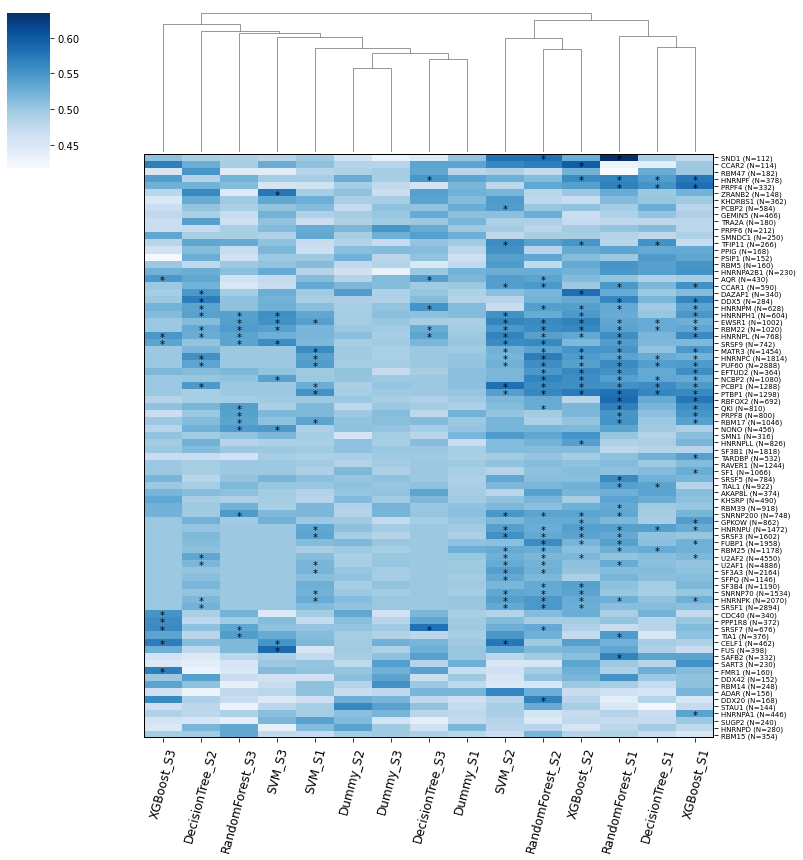

In [258]:
sns.color_palette("Blues_r", as_cmap=True)

accuracies_heat=out_clf.pivot_table(index='RBP_with_N', columns='clf', values='acc').fillna(0.5)
pval_heat = out_clf.pivot_table(index='RBP_with_N', columns='clf', values='pval', dropna=False).fillna(0.8)
pval_heat = pval_heat <= 0.05

g = sns.clustermap(data=accuracies_heat, cmap="Blues", figsize=(12,12), yticklabels=True)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize=12)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize=7)
g.ax_row_dendrogram.set_visible(False)
ax = g.ax_heatmap
ax.set_ylabel("")
ax.set_xlabel("")
ax.axhline(y=0, color='k', linewidth=2)
ax.axhline(y=accuracies_heat.shape[0], color='k', linewidth=2)
ax.axvline(x=0, color='k', linewidth=2)
ax.axvline(x=accuracies_heat.shape[1], color='k', linewidth=2)
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=75)

# Add significance asterisks
for row_i, ix in enumerate(g.dendrogram_row.reordered_ind):
    for col_j, jx in enumerate(g.dendrogram_col.reordered_ind):
   
        text = g.ax_heatmap.text(
            col_j + 0.5,
            row_i + 0.75,
            "*" if pval_heat.iloc[ix, jx] else "",
            ha="center",
            va="center",
            color="black",
        )
        text.set_fontsize(10)
            
plt.savefig('classification_accuracies.pdf')

### Plot fraction of classifiers that have target features in the top 5 of most important for predictions

In [260]:
feat_import = pd.read_csv('tabular_datasets/RESULTS_classification_feat_importances.tsv.gz', sep="\t")

/Users/pbarbosa/miniconda3/envs/genomics/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (1,6,7,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [261]:
rosina_db = ['SF1', 'QKI', 'TARDBP', 'SRSF3', 'TIA1', 'CELF1', 'HNRNPH1', 'SRSF1',
                             'NONO', 'RBM5', 'HNRNPU', 'SART3', 'KHSRP', 'ZRANB2', 'FMR1',
                             'SRSF5', 'PCBP1', 'MATR3', 'HNRNPF', 'SFPQ', 'PTBP1', 'TRA2A',
                             'PCBP2', 'DAZAP1', 'HNRNPK', 'HNRNPLL', 'RBFOX2', 'HNRNPA2B1',
                             'SRSF7', 'SRSF9', 'SNRNP70', 'HNRNPM', 'FUS', 'U2AF2',
                             'HNRNPL', 'KHDRBS1', 'HNRNPA1', 'HNRNPC']

In [262]:
# S3 strategy does not perform well at all. Let's remove from feature importance analysis,
feat_import = feat_import[feat_import.dataset != "occurrences_based_on_location_and_distances"]

feat_import['dataset'] = feat_import.dataset.replace({'occurrences_alone': '_S1',
                                                      'occurrences_based_on_location': '_S2',
                                                      'occurrences_based_on_location_and_distances': '_S3',
                                                      'occurrences_alone_FS': '_S1_FS',
                                                      'occurrences_based_on_location_FS': '_S2_FS'})

feat_import['clf'] = feat_import.classifier + feat_import.dataset

# Remove analysis with feature selection (data leakage problem) and datasets (RBPs) for which there are no motifs available
feat_import = feat_import[~feat_import.dataset.str.contains('_FS')]
feat_import = feat_import[feat_import.RBP.isin(rosina_db)]

In [364]:
def t(df: pd.DataFrame):
    rbp = df.name[0]
    clf = df.name[1]
    # Remove pseudo duplicates by selecting the lowest pvalue
   
    float_cols = ['true_feat_rank', 'pval_true_feat_rank', 'corr_feat_rank', 'pval_corr_feat_rank'] 
 
    df[float_cols] = df[float_cols].astype(float)

    df = df.loc[df.groupby('feat_names').pval_true_feat_rank.idxmin()]
    
    is_top_five = df.iloc[0].true_feat_rank < 5 #or df.iloc[0].corr_feat_rank < 5
    is_sign = df.iloc[0].pval_true_feat_rank < 0.05 #or df.iloc[0].pval_corr_feat_rank < 0.05
    return pd.Series([rbp, clf, is_top_five, is_sign])


In [365]:
feat_import_ = feat_import.groupby(['RBP_with_N', 'clf']).apply(t).reset_index(drop=True)
feat_import_.columns = ['RBP_with_N', 'clf', 'is_top_5', 'is_sign']

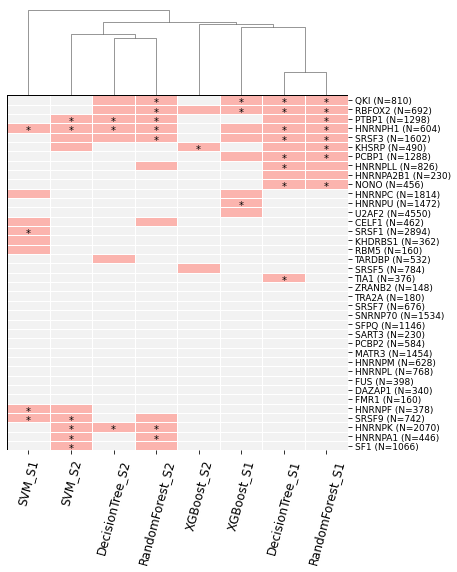

In [367]:
top5_heat=feat_import_.pivot_table(index='RBP_with_N', columns='clf', values='is_top_5')
pval_heat = feat_import_.pivot_table(index='RBP_with_N', columns='clf', values='is_sign', dropna=False)

g = sns.clustermap(data=top5_heat, cmap="Pastel1_r", figsize=(8, 8), yticklabels=True, linewidths=1)
g.cax.set_visible(False)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize=12)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize=9)
g.ax_row_dendrogram.set_visible(False)
ax = g.ax_heatmap
ax.set_ylabel("")
ax.set_xlabel("")
ax.axhline(y=0, color='k', linewidth=2)
ax.axhline(y=accuracies_heat.shape[0], color='k', linewidth=2)
ax.axvline(x=0, color='k', linewidth=2)
ax.axvline(x=accuracies_heat.shape[1], color='k', linewidth=2)
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=75)

# Add significance asterisks
for row_i, ix in enumerate(g.dendrogram_row.reordered_ind):
    for col_j, jx in enumerate(g.dendrogram_col.reordered_ind):
   
        text = g.ax_heatmap.text(
            col_j + 0.5,
            row_i + 0.75,
            "*" if pval_heat.iloc[ix, jx] else "",
            ha="center",
            va="center",
            color="black",
        )
        text.set_fontsize(10)
plt.savefig('in_top5_importance.pdf')